# Continuous Control

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [1]:
!pip -q install ./python 

tensorflow 1.7.1 has requirement numpy>=1.13.3, but you'll have numpy 1.12.1 which is incompatible.
ipython 6.5.0 has requirement prompt-toolkit<2.0.0,>=1.0.15, but you'll have prompt-toolkit 3.0.7 which is incompatible.


The environments corresponding to both versions of the environment are already saved in the Workspace and can be accessed at the file paths provided below.  

Please select one of the two options below for loading the environment.

In [2]:
from unityagents import UnityEnvironment
import numpy as np

# select this option to load version 1 (with a single agent) of the environment
env = UnityEnvironment(file_name='/data/Reacher_One_Linux_NoVis/Reacher_One_Linux_NoVis.x86_64')

# select this option to load version 2 (with 20 agents) of the environment
# env = UnityEnvironment(file_name='/data/Reacher_Linux_NoVis/Reacher.x86_64')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_size -> 5.0
		goal_speed -> 1.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 1
Size of each action: 4
There are 1 agents. Each observes a state with length: 33
The state for the first agent looks like: [  0.00000000e+00  -4.00000000e+00   0.00000000e+00   1.00000000e+00
  -0.00000000e+00  -0.00000000e+00  -4.37113883e-08   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00  -1.00000000e+01   0.00000000e+00
   1.00000000e+00  -0.00000000e+00  -0.00000000e+00  -4.37113883e-08
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   5.75471878e+00  -1.00000000e+00
   5.55726671e+00   0.00000000e+00   1.00000000e+00   0.00000000e+00
  -1.68164849e-01]


In [5]:
brain.vector_action_space_size

4

In [6]:
brain.vector_observation_space_size

33

### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Note that **in this coding environment, you will not be able to watch the agents while they are training**, and you should set `train_mode=True` to restart the environment.

In [7]:
env_info = env.reset(train_mode=True)[brain_name]      # reset the environment    
states = env_info.vector_observations                  # get the current state (for each agent)
scores = np.zeros(num_agents)                          # initialize the score (for each agent)
while True:
    actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
    actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
    env_info = env.step(actions)[brain_name]           # send all actions to tne environment
    next_states = env_info.vector_observations         # get next state (for each agent)
    rewards = env_info.rewards                         # get reward (for each agent)
    dones = env_info.local_done                        # see if episode finished
    scores += env_info.rewards                         # update the score (for each agent)
    states = next_states                               # roll over states to next time step
    if np.any(dones):                                  # exit loop if episode finished
        break
print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

Total score (averaged over agents) this episode: 0.03999999910593033


When finished, you can close the environment.

In [ ]:
env.close()

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  A few **important notes**:
- When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```
- To structure your work, you're welcome to work directly in this Jupyter notebook, or you might like to start over with a new file!  You can see the list of files in the workspace by clicking on **_Jupyter_** in the top left corner of the notebook.
- In this coding environment, you will not be able to watch the agents while they are training.  However, **_after training the agents_**, you can download the saved model weights to watch the agents on your own machine! 

In [8]:
# Importing section

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import random
import numpy as np
import copy

from collections import deque

# Device Selection

In [21]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Hyper-Parameters

In [22]:
BUFFER_SIZE = int(1e6)  
BATCH_SIZE = 128        
GAMMA = 0.99            
TAU = 1e-3          
LR_ACTOR = 1e-4         
LR_CRITIC = 1e-4        
WEIGHT_DECAY = 0   
UPDATE_FREQUENCY = 1
NUM_UPDATES = 1

# Buffer

In [23]:
class Replay_Buffer():
    def __init__(self, capacity, batch_size, seed):
        self.capacity = capacity
        self.batch_size = batch_size
        self.seed = random.seed(seed)
        self.buffer = deque(maxlen = self.capacity)
        return
    
    def add(self, state, action, reward, next_state, is_done):
        self.buffer.append((state, action, reward, next_state, is_done))
        return
    
    def sample(self):
        batch = random.sample(self.buffer, k = self.batch_size)
        
        states, actions, rewards, next_states, is_dones = zip(*batch)
        
        states = torch.FloatTensor(states).view(self.batch_size, -1).to(device)
        actions = torch.FloatTensor(actions).view(self.batch_size, -1).to(device)
        rewards = torch.FloatTensor(rewards).view(self.batch_size, -1).to(device)
        next_states = torch.FloatTensor(next_states).view(self.batch_size, -1).to(device)
        is_dones = torch.FloatTensor(np.float32(is_dones)).view(self.batch_size, -1).to(device)
        
        return (states, actions, rewards, next_states, is_dones)
    
    def __len__(self):
        return len(self.buffer)    

# Noise

### Used to add exploration to our policy

In [24]:
class OUNoise():
    def __init__(self, size, seed , mu = 0., theta = 0.15, sigma =0.2):
        self.mu = mu * np.ones(size)
        self.theta = theta
        self.sigma = sigma
        self.seed = random.seed(seed)
        self.reset()
        return
    
    def reset(self):
        self.state = copy.copy(self.mu)

    def sample(self):
        x = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.array([random.random() for i in range(len(x))])
        self.state = x + dx
        return self.state

# Nets for the Agent

### In this part of the code we are going to set the nets to train our Robot Arm

In [57]:
class Actor(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size, seed):
        super (Actor, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.input_size = input_size
        self.output_size = output_size
        self.hidden_sizes = hidden_sizes
        
        self.Linear_1 = nn.Linear(self.input_size, self.hidden_sizes[0])
        self.Linear_2 = nn.Linear(self.hidden_sizes[0], self.hidden_sizes[1])
        #self.Linear_3 = nn.Linear(self.hidden_sizes[1], self.hidden_sizes[2])
        self.Linear_4 = nn.Linear(self.hidden_sizes[1], self.output_size)
        
        self.relu = nn.ReLU()
        
        self.reset_parameters()
        return
    
    def reset_parameters(self):
        # This is useful to initialize parameters
        normalization_factor_1 = self.Linear_1.weight.data.size()[0]
        value_1 = 1. / np.sqrt(normalization_factor_1)
        self.Linear_1.weight.data.uniform_(-value_1, value_1)
        
        normalization_factor_2 = self.Linear_2.weight.data.size()[0]
        value_2 = 1. / np.sqrt(normalization_factor_2)
        self.Linear_2.weight.data.uniform_(-value_2, value_2)
        
        #normalization_factor_3 = self.Linear_3.weight.data.size()[0]
        #value_3 = 1. / np.sqrt(normalization_factor_3)
        #self.Linear_3.weight.data.uniform_(-value_3, value_3)
        
        self.Linear_4.weight.data.uniform_(-3e-3, 3e-3)
        return
    
    def forward(self, state):
        state = self.relu(self.Linear_1(state))
        state = self.relu(self.Linear_2(state))
        #state = self.relu(self.Linear_3(state))
        actions = torch.tanh(self.Linear_4(state))
        return actions
    
class Critic(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size, seed):
        super(Critic, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.input_size = input_size
        self.output_size = output_size
        self.hidden_sizes = hidden_sizes
            
        self.Linear_1 = nn.Linear(self.input_size, self.hidden_sizes[0])
        self.Linear_2 = nn.Linear(self.hidden_sizes[0] + self.output_size, self.hidden_sizes[1])
        #self.Linear_3 = nn.Linear(self.hidden_sizes[1], self.hidden_sizes[2])
        #self.Linear_4 = nn.Linear(self.hidden_sizes[2], self.hidden_sizes[3])
        self.Linear_5 = nn.Linear(self.hidden_sizes[1], 1)
            
        # CHECK! NOTICE HERE THEY USE LEAKY RELU
        self.relu = nn.ReLU()
            
        self.reset_parameters()
        return
            
    def reset_parameters(self):
        normalization_factor_1 = self.Linear_1.weight.data.size()[0]
        value_1 = 1. / np.sqrt(normalization_factor_1)
        self.Linear_1.weight.data.uniform_(-value_1, value_1)
        
        normalization_factor_2 = self.Linear_2.weight.data.size()[0]
        value_2 = 1. / np.sqrt(normalization_factor_2)
        self.Linear_2.weight.data.uniform_(-value_2, value_2)
            
        #normalization_factor_3 = self.Linear_3.weight.data.size()[0]
        #value_3 = 1. / np.sqrt(normalization_factor_3)
        #self.Linear_3.weight.data.uniform_(-value_3, value_3)
        
        #normalization_factor_4 = self.Linear_4.weight.data.size()[0]
        #value_4 = 1. / np.sqrt(normalization_factor_4)
        #self.Linear_4.weight.data.uniform_(-value_3, value_3)
        
        self.Linear_5.weight.data.uniform_(-3e-3, 3e-3)
        return
        
    def forward(self, state, action):
        state = F.leaky_relu(self.Linear_1(state))
        state_action = torch.cat((state, action), dim = 1)
        state = F.leaky_relu(self.Linear_2(state_action))
        #state = F.leaky_relu(self.Linear_3(state))
        #state = self.relu(self.Linear_4(state))
        state = self.Linear_5(state)
            
        return state       

# Agent

In [58]:
class Agent():
    def __init__(self, input_size, output_size, hidden_sizes_actor, hidden_sizes_critic, random_seed):
        
        self.input_size = input_size
        self.output_size = output_size
        self.hidden_sizes_actor = hidden_sizes_actor
        self.hidden_sizes_critic = hidden_sizes_critic
        self.seed = random.seed(random_seed)
        
        # Notice. It is not important to initialize the actor and the critic targets since by default actor and actor_tg, and similarly critic and critic_tg,
        # have the same weights
        self.actor = Actor(self.input_size, self.hidden_sizes_actor, self.output_size, random_seed).to(device)
        self.actor_tg = Actor(self.input_size, self.hidden_sizes_actor, self.output_size, random_seed).to(device)
        
        self.critic = Critic(self.input_size, self.hidden_sizes_critic, self.output_size, random_seed).to(device)
        self.critic_tg = Critic(self.input_size, self.hidden_sizes_critic, self.output_size, random_seed).to(device)
        
        self.actor_optimizer = optim.Adam (self.actor.parameters(), lr = LR_ACTOR)
        self.critic_optimizer = optim.Adam (self.critic.parameters(), lr = LR_CRITIC)
        
        self.noise = OUNoise(self.output_size, random_seed)
        self.buffer = Replay_Buffer(BUFFER_SIZE, BATCH_SIZE, random_seed)
    
    def act(self, state, parameter_noise = True):
        state = torch.FloatTensor(state).to(device)
        self.actor.eval()
        
        with torch.no_grad():
            action = self.actor(state).cpu().data.numpy()
        
        self.actor.train()
        
        if parameter_noise == True:
            action += self.noise.sample()
            
        return  np.clip(action, -1, 1)
    
    def reset(self):
        self.noise.reset()
        
    def step(self, state, action, reward, next_state, is_done, count):
        self.buffer.add(state, action, reward, next_state, is_done)
    
        if (len(self.buffer) > BATCH_SIZE) and (count % UPDATE_FREQUENCY == 0):
            policy_loss = 0
            critic_loss = 0
            
            for i in range(NUM_UPDATES):
                batch = self.buffer.sample()
                policy_loss_temp, critic_loss_temp = self.learn(batch, GAMMA)
                
                policy_loss += policy_loss_temp
                critic_loss += critic_loss_temp
            
            return policy_loss, critic_loss
    
    def learn(self, batch, gamma):
        states = batch[0]
        actions = batch[1]
        rewards = batch[2]
        next_states = batch[3]
        is_dones = batch[4]
        
        # UPDATING CRITIC
        
        # Target Values of the Critic
        
        next_actions = self.actor_tg(next_states)
        Q_next_states = self.critic_tg(next_states, next_actions)
        Q_targets = rewards + GAMMA * Q_next_states * (1.0 - is_dones)
        
        # Q_values 
        
        Q_values = self.critic(states, actions)
        critic_loss = F.mse_loss(Q_targets.detach(), Q_values)
        
        # Updates
        
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        torch.nn.utils.clip_grad_norm_(self.critic.parameters(), 1)
        self.critic_optimizer.step()
        
        # UPDATING POLICY
        
        actions_pred = self.actor(states)
        Q = self.critic(states, actions_pred)
        policy_loss = -Q.mean()
        
        self.actor_optimizer.zero_grad()
        policy_loss.backward()
        self.actor_optimizer.step()
        
        # SOFT_UPDATE
        
        self.soft_update(self.actor, self.actor_tg, TAU)
        self.soft_update(self.critic, self.critic_tg, TAU)
        
        return policy_loss, critic_loss
        
    def soft_update(self, net, net_tg, TAU):
        
        for target_param, local_param in zip(net_tg.parameters(), net.parameters()):
            target_param.data.copy_(TAU*local_param.data + (1.0-TAU)*target_param.data)
            
        return       

# Instatiating all the necessary objects

In [59]:
hidden_layers_actor = [256, 128]

In [60]:
hidden_layers_critic = [256, 128]

In [61]:
agent = Agent(brain.vector_observation_space_size, brain.vector_action_space_size, hidden_layers_actor, hidden_layers_critic, 1)

In [26]:
agent.actor.load_state_dict(torch.load('checkpoint_actor.pth'))
agent.critic.load_state_dict(torch.load('checkpoint_critic.pth'))
agent.actor_tg.load_state_dict(torch.load('checkpoint_actor.pth'))
agent.critic_tg.load_state_dict(torch.load('checkpoint_critic.pth'))
agent.buffer = torch.load('checkpoint_buffer.pth')

In [43]:
print(len(agent.buffer))

200200


# DDPG main

In [75]:
def main(num_episodes):
    count = 1
    scores = []
    scores_deque = deque(maxlen = 100)
    policy_losses = []
    critic_losses = []
    
    for i in range(1, num_episodes + 1):
        env_info = env.reset(train_mode=True)[brain_name]      # reset the environment    
        state = env_info.vector_observations                  # get the current state (for each agent)
        score = 0
        agent.reset() # Resetting the noice
        
        while True:
            action = agent.act(state)
            env_info = env.step(action)[brain_name]           
            next_state = env_info.vector_observations         
            reward = env_info.rewards

            if reward[0]>0: 
                reward = reward[0]*10 + 0.1 
            else:
                reward = 0
          
            is_done = env_info.local_done   
            
            agent.step(state, action, reward, next_state, is_done,count)
            
            if reward>0: 
                reward = 0.1 
            else:
                reward = 0
       
            #print('episode {} reward {}'.format(i, reward))
            score += reward                     
            state = next_state 
            
            if np.any(is_done):
                scores.append(score)
                scores_deque.append(score)
                print('At episode {} the score obtained is {}'.format(i, score))
      
                count += 1
                break
            
            count += 1
        
        if i%10 == 0:
            temp = scores[-10:]
            print( 'Score mean ', np.mean(temp))
        if i % 100 == 0:
            torch.save(agent.actor.state_dict(), 'checkpoint_actor.pth')
            torch.save(agent.critic.state_dict(), 'checkpoint_critic.pth')
            print('\n### Episode {}\tAverage Score: {:.2f} ###\n'.format(i, np.mean(scores_deque)))   

        if len(scores_deque) == 100 and (np.mean(scores_deque) >= 30):
            print('The environment was solved')
            torch.save(agent.actor.state_dict(), 'checkpoint_actor.pth')
            torch.save(agent.critic.state_dict(), 'checkpoint_critic.pth')
            return scores                

In [79]:
scores = main(200)

At episode 1 the score obtained is 24.70000000000008
At episode 2 the score obtained is 33.0000000000002
At episode 3 the score obtained is 30.800000000000168
At episode 4 the score obtained is 30.700000000000166
At episode 5 the score obtained is 37.20000000000026
At episode 6 the score obtained is 30.20000000000016
At episode 7 the score obtained is 35.30000000000023
At episode 8 the score obtained is 24.400000000000077
At episode 9 the score obtained is 31.200000000000173
At episode 10 the score obtained is 37.90000000000027
Score mean  31.54
At episode 11 the score obtained is 31.100000000000172
At episode 12 the score obtained is 32.30000000000019
At episode 13 the score obtained is 33.80000000000021
At episode 14 the score obtained is 29.50000000000015
At episode 15 the score obtained is 33.90000000000021
At episode 16 the score obtained is 33.70000000000021
At episode 17 the score obtained is 28.700000000000138
At episode 18 the score obtained is 78.09999999999984
At episode 19 

In [80]:
import matplotlib.pyplot as plt

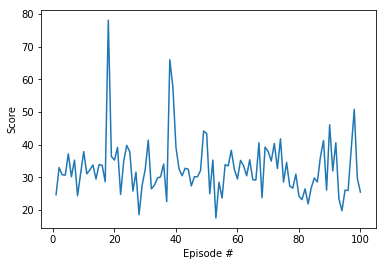

In [81]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

# Prio Buffer

In [11]:
class Replay_Buffer(object):
    def __init__(self, capacity, batch_size, prob_alpha=0.6):
        self.prob_alpha = prob_alpha
        self.capacity   = capacity
        self.batch_size = batch_size
        self.buffer     = []
        self.pos        = 0
        self.priorities = np.zeros((capacity,), dtype=np.float32)
    
    def add(self, state, action, reward, next_state, is_done):
        
        max_prio = self.priorities.max() if self.buffer else 1.0
        
        
        if len(self.buffer) < self.capacity:
            self.buffer.append((state, action, reward, next_state, is_done))
        else:
            self.buffer[self.pos] = (state, action, reward, next_state, is_done)
        
        self.priorities[self.pos] = max_prio
        self.pos = (self.pos + 1) % self.capacity

    def sample(self,  beta=0.4):
        if len(self.buffer) == self.capacity:
            prios = self.priorities
        else:
            prios = self.priorities[:self.pos]
        
        probs  = prios ** self.prob_alpha
        probs /= probs.sum()
        
        indices = np.random.choice(len(self.buffer), self.batch_size, p=probs)
        samples = [self.buffer[idx] for idx in indices]
        
        total    = len(self.buffer)
        weights  = (total * probs[indices]) ** (-beta)
        weights /= weights.max()
        weights  = np.array(weights, dtype=np.float32)
        
        states, actions, rewards, next_states, is_dones = zip(*samples)
        
        states = torch.FloatTensor(states).view(self.batch_size, -1).to(device)
        actions = torch.FloatTensor(actions).view(self.batch_size, -1).to(device)
        rewards = torch.FloatTensor(rewards).view(self.batch_size, -1).to(device)
        next_states = torch.FloatTensor(next_states).view(self.batch_size, -1).to(device)
        is_dones = torch.FloatTensor(np.float32(is_dones)).view(self.batch_size, -1).to(device)
        weights = torch.FloatTensor(weights).view(self.batch_size, -1).to(device)
    
        return (states, actions, rewards, next_states, is_dones, indices, weights)
    
    def update_priorities(self, batch_indices, batch_priorities):
        for idx, prio in zip(batch_indices, batch_priorities):
            self.priorities[idx] = prio

    def __len__(self):
        return len(self.buffer)

# Beta Function

In [12]:
def beta_function (number, beta_start = 0.4):
    return min(1.0, beta_start + number * (1.0 - beta_start) / 1000)

# Agent_for_replay

In [15]:
class Agent():
    def __init__(self, input_size, output_size, hidden_sizes_actor, hidden_sizes_critic, random_seed):
        
        self.input_size = input_size
        self.output_size = output_size
        self.hidden_sizes_actor = hidden_sizes_actor
        self.hidden_sizes_critic = hidden_sizes_critic
        self.seed = random.seed(random_seed)
        
        # Notice. It is not important to initialize the actor and the critic targets since by default actor and actor_tg, and similarly critic and critic_tg,
        # have the same weights
        self.actor = Actor(self.input_size, self.hidden_sizes_actor, self.output_size, random_seed).to(device)
        self.actor_tg = Actor(self.input_size, self.hidden_sizes_actor, self.output_size, random_seed).to(device)
        
        self.critic = Critic(self.input_size, self.hidden_sizes_critic, self.output_size, random_seed).to(device)
        self.critic_tg = Critic(self.input_size, self.hidden_sizes_critic, self.output_size, random_seed).to(device)
        
        self.actor_optimizer = optim.Adam (self.actor.parameters(), lr = LR_ACTOR)
        self.critic_optimizer = optim.Adam (self.critic.parameters(), lr = LR_CRITIC, weight_decay = WEIGHT_DECAY)
        
        self.noise = OUNoise(self.output_size, random_seed)
        self.buffer = Replay_Buffer(BUFFER_SIZE, BATCH_SIZE, random_seed)
    
    def act(self, state, parameter_noise = True):
        state = torch.FloatTensor(state).to(device)
        self.actor.eval()
        
        with torch.no_grad():
            action = self.actor(state).cpu().data.numpy()
        
        self.actor.train()
        
        if parameter_noise == True:
            action += self.noise.sample()
            
        return  np.clip(action, -1, 1)
    
    def reset(self):
        self.noise.reset()
        
    def step(self, state, action, reward, next_state, is_done, count, beta):
        self.buffer.add(state, action, reward, next_state, is_done)
        
        if (len(self.buffer) > BATCH_SIZE) and (count % UPDATE_FREQUENCY == 0):

            policy_loss = 0
            critic_loss = 0
            
            for i in range(NUM_UPDATES):
                batch = self.buffer.sample(beta)
                policy_loss_temp, critic_loss_temp = self.learn(batch, GAMMA, beta)
                
                policy_loss += policy_loss_temp
                critic_loss += critic_loss_temp
            
            return policy_loss, critic_loss
        return None, None
    
    def learn(self, batch, gamma, beta):
        states = batch[0]
        actions = batch[1]
        rewards = batch[2]
        next_states = batch[3]
        is_dones = batch[4]
        indices = batch[5]
        weights = batch[6]
        #print(rewards.dtype)
        
        # UPDATING CRITIC

        # Target Values of the Critic
        
        next_actions = self.actor_tg(next_states)
        Q_next_states = self.critic_tg(next_states, next_actions)
        Q_targets = rewards + GAMMA * Q_next_states * (1.0 - is_dones)
        
        # Q_values 
        
        Q_values = self.critic(states, actions)
        critic_loss = (Q_values - Q_targets.detach()).pow(2) * weights
        prios = critic_loss + 1e-5
        critic_loss  = critic_loss.mean()
        
        # Updates
        
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        torch.nn.utils.clip_grad_norm(self.critic.parameters(), 1)
        self.buffer.update_priorities(indices, prios.data.cpu().numpy())
        self.critic_optimizer.step()
        
        # UPDATING POLICY
        
        actions = self.actor(states)
        Q_targets = self.critic(states, actions)
        policy_loss = -Q_targets.mean()
        
        self.actor_optimizer.zero_grad()
        policy_loss.backward()
        torch.nn.utils.clip_grad_norm(self.actor.parameters(), 1)
        self.actor_optimizer.step()
        
        # SOFT_UPDATE
        
        self.soft_update(self.actor, self.actor_tg, TAU)
        self.soft_update(self.critic, self.critic_tg, TAU)
        
        return policy_loss, critic_loss
        
    def soft_update(self, net, net_tg, tau):
        
        for param, param_tg in zip(net.parameters(), net_tg.parameters()):
            param_tg.data.copy_( param.data + TAU * (param_tg.data - param.data))
            
        return       

# Main For Replay

In [73]:
def main(num_episodes):
    count = 1
    scores = []
    scores_deque = deque(maxlen = 100)
    policy_losses = []
    critic_losses = []
    
    for i in range(1, num_episodes + 1):
        env_info = env.reset(train_mode=True)[brain_name]      # reset the environment    
        state = env_info.vector_observations                  # get the current state (for each agent)
        score = 0
        agent.reset() # Resetting the noice
        
        while True:
            action = agent.act(state)
            env_info = env.step(action)[brain_name]           
            next_state = env_info.vector_observations         
            reward = env_info.rewards
            
            # Normalizing  the reward since it was not spitting out the right one
            if reward[0]>0: 
                reward = 1 + reward[0]*10 
            else:
                reward = 0.0
   
            is_done = env_info.local_done   
            
            beta = beta_function(count)
            agent.step(state, action, reward, next_state, is_done, count, beta)
            
            
       
            #print('episode {} reward {}'.format(i, reward))
            
            if reward > 0:
                reward = 0.1
                
            score += reward                     
            state = next_state 
            
            if np.any(is_done):
                scores.append(score)
                scores_deque.append(score)
                print('At episode {} the score obtained is {}'.format(i, score))
      
                count += 1
                break
            
            count += 1
            
        if i % 100 == 0:
            torch.save(agent.actor.state_dict(), 'checkpoint_actor.pth')
            torch.save(agent.critic.state_dict(), 'checkpoint_critic.pth')
            torch.save(agent.buffer, 'checkpoint_buffer.pth')
            print('\n### Episode {}\tAverage Score: {:.2f} ###\n'.format(i, np.mean(scores_deque)))   

        if len(scores_deque) == 100 and (np.mean(scores_deque) >= 30):
            print('The environment was solved')
            torch.save(agent.actor.state_dict(), 'checkpoint_actor.pth')
            torch.save(agent.critic.state_dict(), 'checkpoint_critic.pth')
            return scores          